ref for data preprocessing & postprocessing: https://www.kaggle.com/code/gordonyip/host-starter-solution

# imports and intializations

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
# from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from pytorch_lightning.loggers import CSVLogger #,TensorBoardLogger #,WandbLogger


seed = 42
pl.seed_everything(seed)

# trainer
accelerator = 'gpu'
devices = 1



[rank: 0] Seed set to 42


# load dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import pandas as pd
import seaborn as sns



In [26]:
task = '1dlinearae'

data_folder = '/home/ulaval.ca/maelr5/scratch/binned-dataset-v1/' # path to the folder containing the data
auxiliary_folder = '/home/ulaval.ca/maelr5/scratch/ariel-data-challenge/' # path to the folder containing the train targets and wavelengths informations

data_train = np.load(f'{data_folder}/data_train.npy')
data_train_FGS = np.load(f'{data_folder}/data_train_FGS.npy')

output_dir = f'/home/ulaval.ca/maelr5/scratch/{task}_output' #'./output'

do_the_mcdropout_wc = True
do_the_mcdropout = True

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")



Directory /home/ulaval.ca/maelr5/scratch/1dlinearae_output created.


# 1D-CNN for mean transit depth

## preprocess 1D CNN

In [27]:
train_df = pd.read_csv(f'{auxiliary_folder}/train_labels.csv')
print(len(train_df))
train_df.head()


673


,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,wl_274,wl_275,wl_276,wl_277,wl_278,wl_279,wl_280,wl_281,wl_282,wl_283
0,785834,0.001086,0.001137,0.001131,0.001124,0.001138,0.001131,0.001123,0.001127,0.001120,...,0.001075,0.001076,0.001076,0.001076,0.001074,0.001073,0.001072,0.001073,0.001073,0.001072
1,14485303,0.001835,0.001835,0.001834,0.001833,0.001833,0.001833,0.001833,0.001834,0.001834,...,0.001893,0.001892,0.001892,0.001891,0.001891,0.001891,0.001890,0.001890,0.001889,0.001888
2,17002355,0.002792,0.002814,0.002808,0.002804,0.002809,0.002805,0.002802,0.002805,0.002801,...,0.002784,0.002783,0.002783,0.002783,0.002783,0.002784,0.002784,0.002785,0.002785,0.002784
3,24135240,0.001294,0.001308,0.001308,0.001306,0.001306,0.001303,0.001306,0.001314,0.001314,...,0.001405,0.001404,0.001403,0.001402,0.001401,0.001400,0.001399,0.001397,0.001395,0.001393
4,25070640,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,0.001987,...,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988,0.001988


In [28]:
train_solution = np.loadtxt(f'{auxiliary_folder}/train_labels.csv', delimiter = ',', skiprows = 1)

targets = train_solution[:,1:]
targets_mean = targets[:,1:].mean(axis = 1) # used for the 1D-CNN to extract the mean value, only AIRS wavelengths as the FGS point is not used in the white curve
N = targets.shape[0]
print(N, targets.shape, targets_mean.shape)

print(data_train.shape, data_train_FGS.shape)


signal_AIRS_diff_transposed_binned, signal_FGS_diff_transposed_binned  = data_train, data_train_FGS
FGS_column = signal_FGS_diff_transposed_binned.sum(axis = 2)
dataset = np.concatenate([signal_AIRS_diff_transposed_binned, FGS_column[:,:, np.newaxis,:]], axis = 2)
print('dataset shape= ', dataset.shape)

dataset = dataset.sum(axis=3)
print('dataset shape= ', dataset.shape)

def create_dataset_norm(dataset1, dataset2) :
    dataset_norm1 = np.zeros(dataset1.shape)
    dataset_norm2 = np.zeros(dataset1.shape)
    dataset_min = dataset1.min()
    dataset_max = dataset1.max()
    dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
    dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - dataset_min)
    return dataset_norm1, dataset_norm2


def norm_star_spectrum (signal) :
    img_star = signal[:,:50].mean(axis = 1) + signal[:,-50:].mean(axis = 1)
    return signal/img_star[:,np.newaxis,:]

dataset_norm = norm_star_spectrum(dataset)
print(dataset_norm.shape)
dataset_norm = np.transpose(dataset_norm,(0,2,1))
print(dataset_norm.shape)


cut_inf, cut_sup = 39, 321 # we have previously cut the data along the wavelengths to remove the edges, this is to match with the targets range in the make data 
# file
l = cut_sup - cut_inf + 1
wls = np.arange(l)


def split (data, N) :
    list_planets = random.sample(range(0, data.shape[0]), N_train)
    list_index_1 = np.zeros(data.shape[0], dtype = bool)
    for planet in list_planets :
        list_index_1[planet] = True
    data_1 = data[list_index_1]
    data_2 = data[~list_index_1]
    return data_1, data_2, list_index_1

N_train = 8*N//10

# Validation and train data split
train_obs, valid_obs, list_index_train = split(dataset_norm, N_train)
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]


print(train_obs.shape, valid_obs.shape, train_targets.shape, valid_targets.shape)



673 (673, 283) (673,)
(673, 187, 282, 32) (673, 187, 32, 32)
dataset shape=  (673, 187, 283, 32)
dataset shape=  (673, 187, 283)
(673, 187, 283)
(673, 283, 187)
(538, 283, 187) (135, 283, 187) (538, 283) (135, 283)


In [29]:

signal_AIRS_diff_transposed_binned = signal_AIRS_diff_transposed_binned.sum(axis=3)
wc_mean = signal_AIRS_diff_transposed_binned.mean(axis=1).mean(axis=1)
white_curve = signal_AIRS_diff_transposed_binned.sum(axis=2)/ wc_mean[:, np.newaxis]
print('wc_mean:',wc_mean.shape, ' white_curve:', white_curve.shape, wc_mean[:, np.newaxis].shape)




wc_mean: (673,)  white_curve: (673, 187) (673, 1)


(538, 187) (135, 187) (538,) (135,) 0.0003986691051293762 0.007354582286725231


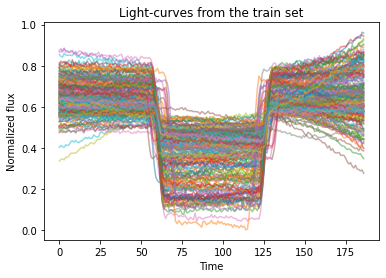

In [30]:


def normalise_wlc(train, valid) :

    wlc_train_min = train.min()
    wlc_train_max = train.max()
    train_norm = (train - wlc_train_min) / (wlc_train_max - wlc_train_min)
    valid_norm = (valid - wlc_train_min) / (wlc_train_max - wlc_train_min)

    return train_norm, valid_norm

def normalize(train, valid) :
    max_train = train.max()
    min_train = train.min()
    train_norm = (train - min_train) / (max_train - min_train)
    valid_norm = (valid - min_train) / (max_train - min_train)
    return train_norm, valid_norm, min_train, max_train

# Split the light curves and targets
train_wc, valid_wc = white_curve[list_index_train], white_curve[~list_index_train]
train_targets_wc, valid_targets_wc = targets_mean[list_index_train], targets_mean[~list_index_train]

# Normalize the wlc
train_wc, valid_wc = normalise_wlc(train_wc, valid_wc)

# Normalize the targets
train_targets_wc_norm, valid_targets_wc_norm, min_train_valid_wc, max_train_valid_wc = normalize(train_targets_wc,
                                                                                                 valid_targets_wc)
print(train_wc.shape, valid_wc.shape, train_targets_wc_norm.shape, valid_targets_wc_norm.shape, min_train_valid_wc, 
      max_train_valid_wc)

plt.figure()
for i in range (200) :
    plt.plot(train_wc[-i], '-', alpha = 0.5)
plt.title('Light-curves from the train set')
plt.xlabel('Time')
plt.ylabel('Normalized flux')
plt.show()




In [31]:
train_wc = train_wc.reshape(train_wc.shape[0], 1, train_wc.shape[1])
valid_wc = valid_wc.reshape(valid_wc.shape[0], 1, valid_wc.shape[1])
print(train_wc.shape, valid_wc.shape)



(538, 1, 187) (135, 1, 187)


In [32]:
valid_wc.dtype



dtype('float64')

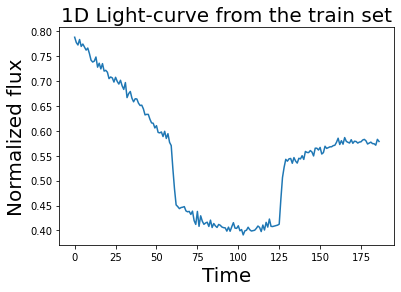

In [33]:
plt.plot(train_wc[0][0])
plt.title('1D Light-curve from the train set', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Normalized flux', fontsize=20)
plt.show()



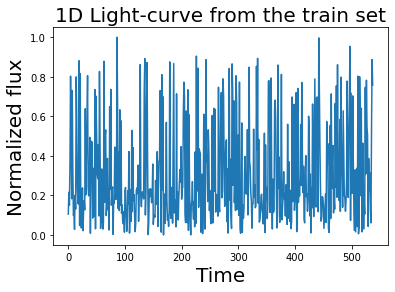

In [34]:
# train_targets_wc_norm.shape
plt.plot(train_targets_wc_norm)
plt.title('1D Light-curve from the train set', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Normalized flux', fontsize=20)
plt.show()




## dataset class

In [69]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        super().__init__()
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.targets)
        
    def __getitem__(self, index):
        return (self.data[index], self.targets[index])
    

    

In [70]:
print(output_dir)



/home/ulaval.ca/maelr5/scratch/1dlinearae_output


In [37]:
# dataset
# data_dir
# output_dir = '/home/ulaval.ca/maelr5/scratch/baseline_output'
ckpt_dir = output_dir + "/checkpoints"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created.")
else:
    print(f"Directory {output_dir} already exists.")

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    print(f"Directory {ckpt_dir} created.")
else:
    print(f"Directory {ckpt_dir} already exists.")

    
    

Directory /home/ulaval.ca/maelr5/scratch/1dlinearae_output already exists.
Directory /home/ulaval.ca/maelr5/scratch/1dlinearae_output/checkpoints created.


## trainer callbacks

In [46]:
subtask = '1DAE'

# Trainer callbacks
callbacks = []
callbacks.append(
    ModelCheckpoint(
        monitor='val_loss',
        save_top_k=1,
        save_last=True,
        dirpath=ckpt_dir+f'/{subtask}/',
        filename=f'{subtask}_{task}'+'-{epoch}-{val_loss:.2f}',
        verbose=False,
        mode='min',
    ) 
)

callbacks.append(
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        mode='min',
    )
)
    
callbacks.append(LearningRateMonitor(logging_interval="epoch"))

    

## create 1D AE model & module

In [77]:

# optimizer
lr = 0.001

# dataloader
batch_size = 16

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class OneDConvAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(OneDConvAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(187, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim//2),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim//2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 1),
            nn.Tanh() #best soln
        )
        
#         self.avgpool = nn.AdaptiveAvgPool1d((50))
#         self.linear = nn.Linear(50,1)
        
    def forward(self, x):
        # print(x.dtype)
        x = self.encoder(x.float())
        x = self.decoder(x)
        return x.squeeze(-1)
        # x = self.avgpool(x)
        # x = Flatten()(x)
        # return self.linear(x)
        
# convolutional autoencoder
# class OneDConvAE(nn.Module):
#     def __init__(self):
#         super(OneDConvAE, self).__init__()
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU()
#         )
        
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),#, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),#, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),#, output_padding=1),
#         )
        
#         self.avgpool = nn.AdaptiveAvgPool1d((50))
#         self.linear = nn.Linear(50,1)
        
#     def forward(self, x):
#         # print(x.dtype)
#         x = self.encoder(x.float())
#         x = self.decoder(x)
#         x = self.avgpool(x)
#         x = Flatten()(x)
#         return self.linear(x)

class BaseModule(pl.LightningModule):
    def __init__(self, train_data, train_labels, valid_data, valid_labels):
        super().__init__()

        self.model = OneDConvAE()
        self.save_hyperparameters()
        self.loss = nn.MSELoss()
        # print(train_data.dtype, valid_data.dtype)
        self.tr = MyDataset(train_data, train_labels)
        # print(self.train)
        self.v = MyDataset(valid_data, valid_labels)
        # self.test = 
        self.validation_step_outputs = []

    def train_dataloader(self):
        train_loader = DataLoader(self.tr, batch_size=batch_size, shuffle=True, num_workers=4)
        # print(train_loader)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.v, batch_size=batch_size, shuffle=False, num_workers=4)
        return val_loader
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200 , gamma=0.2)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        x, y = batch

        batch_size = x.size(0)
        y = y.float()
        # x = x.view(batch_size, -1).float()
        # print(x.shape, y.shape)

        logits = self(x)
        loss = self.loss(logits, y).float()
        # acc = Accuracy(logits, y)
        # pbar = {'train_acc': acc}
        self.log('train_loss', loss, on_step=True, on_epoch=True)

        return loss # {'train_loss': loss} #, 'progress_bar': pbar}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()

        batch_size = x.size(0)
        # x = x.view(batch_size, -1)

        logits = self(x)
        loss = self.loss(logits, y)
        self.validation_step_outputs.append(loss)
        self.log('val_loss', loss)
        # acc = Accuracy(logits, y)
        # pbar = {'val_acc': acc}

        return loss # {'loss': loss} #, 'progress_bar': pbar}
    
    def on_validation_epoch_end(self):
        # all_preds = torch.stack(self.validation_step_outputs)
        avg_val_loss = torch.tensor([x for x in self.validation_step_outputs]).mean()
        # avg_val_acc = torch.tensor([x['progress_bar']['val_acc'] for x in val_step_outputs]).mean()
        # pbar = {'avg_val_loss': avg_val_loss}
        self.log('avg_val_loss', avg_val_loss, prog_bar=True)
        self.validation_step_outputs.clear()  # Free memory

        # return {'val_loss': avg_val_loss, 'progress_bar': pbar}
    
    

## fit the train data

In [60]:
output_dir




'/home/ulaval.ca/maelr5/scratch/1dlinearae_output'

In [61]:
np.expand_dims(valid_targets_wc_norm, axis=1).shape, np.expand_dims(train_targets_wc_norm, axis=1).shape



((135, 1), (538, 1))

In [62]:

csv_logger = CSVLogger(output_dir + "/csv_logs/", name=subtask)
max_epochs = 1200

# make Pytorch Lightning trainer
trainer = pl.Trainer(
    logger=csv_logger,
    # default_root_dir = output_dir, # saves checkpoints to 'some/path/' at every epoch end
    max_epochs=max_epochs,
    callbacks=callbacks,
    accelerator = 'gpu',
    devices = 1,
)

# ckpt_resume_path = ''
module = BaseModule(train_wc, np.expand_dims(train_targets_wc_norm, axis=1), valid_wc, np.expand_dims(valid_targets_wc_norm, axis=1))

print('Running ...')
# fitting procedure
trainer.fit(
    model=module,
    # ckpt_path=ckpt_resume_path,
)
print('Done.')



Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /scratch/maelr5@ulaval.ca/1dlinearae_output/checkpoints/1DAE exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | OneDConvAE | 40.8 K | train
1 | loss  | MSELoss    | 0      | train
---------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Running ...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1200` reached.


Done.


## visualize the train/val loss

In [75]:
cnn1d_csv = pd.read_csv("/home/ulaval.ca/maelr5/scratch/1dae_2dunet_output/csv_logs/1DAE/version_0/metrics.csv")
# cnn1d_csv = pd.read_csv("/home/ulaval.ca/maelr5/scratch/1dlinearae_output/csv_logs/1DAE/version_2/metrics.csv")
# print(len(cnn1d_csv))
cnn1d_csv.head()



,avg_val_loss,epoch,lr-SGD,step,train_loss_epoch,train_loss_step,val_loss
0,NaN,NaN,0.001,0,NaN,NaN,NaN
1,0.073897,0.0,NaN,33,NaN,NaN,0.077814
2,NaN,0.0,NaN,33,0.126069,NaN,NaN
3,NaN,NaN,0.001,34,NaN,NaN,NaN
4,NaN,1.0,NaN,49,NaN,0.08977,NaN


/tmp/ipykernel_1152377/1420977990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename({'train_loss_epoch':'loss'}, axis=1, inplace=True)
/tmp/ipykernel_1152377/1420977990.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mode'] = 'train_loss_epoch'
/tmp/ipykernel_1152377/1420977990.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.rename({'avg_val_loss':'l

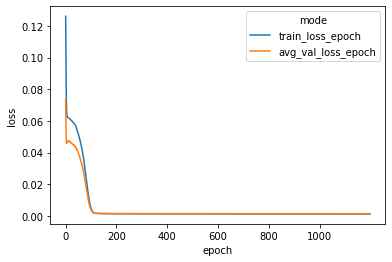

In [76]:

# max_epochs=5
df1 = cnn1d_csv[['epoch','train_loss_epoch']]
df1.rename({'train_loss_epoch':'loss'}, axis=1, inplace=True)
df1['mode'] = 'train_loss_epoch'

df2 = cnn1d_csv[['epoch','avg_val_loss']]
df2.rename({'avg_val_loss':'loss'}, axis=1, inplace=True)
df2['mode'] = 'avg_val_loss_epoch'

results = pd.concat([df1, df2], ignore_index=True, sort=False)

# results

ax1 = sns.lineplot(data=results, x ='epoch' , y='loss', hue='mode')

plt.xticks(np.arange(0,max_epochs,200))

plt.show()


## 1D CNN Inference

we perform the MC Dropout to obtain the mean prediction and the uncertainty associated. We choose to compute 1000 instances.


In [22]:
valid_wc.shape


(135, 1, 187)

In [78]:

# https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html#lightningmodule-from-checkpoint
# model_wc = BaseModule.load_from_checkpoint("/home/ulaval.ca/maelr5/scratch/1dae_2dunet_output/checkpoints/1DAE/1DAE_1dae_2dunet-epoch=1199-val_loss=0.00.ckpt").cpu()
model_wc = BaseModule.load_from_checkpoint("/home/ulaval.ca/maelr5/scratch/1dlinearae_output/checkpoints/1DAE/1DAE_1dlinearae-epoch=1199-val_loss=0.01.ckpt").cpu()
# disable randomness, dropout, etc...
model_wc.eval()
# predict with the model
y_hat = model_wc(torch.tensor(valid_wc))
print(y_hat.shape)



torch.Size([135, 1])


Running ...
predictions shape=  (1000, 135)
Done.


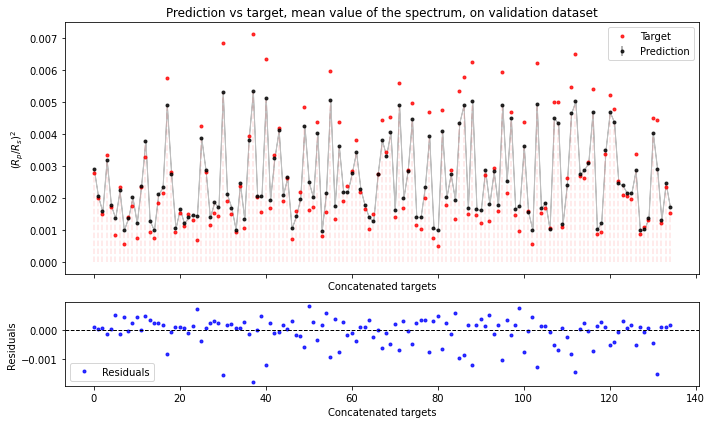

In [79]:
nb_dropout_wc = 1000

def unstandardizing(data, min_train_valid, max_train_valid) :
    return data * (max_train_valid - min_train_valid) + min_train_valid

def MC_dropout_WC(model, data, nb_dropout) :
    predictions = np.zeros((nb_dropout, data.shape[0]))
    for i in range(nb_dropout) :
        predictions[i,:] = model(torch.tensor(data)).flatten().detach().numpy()
    print('predictions shape= ', predictions.shape)
    return predictions

if do_the_mcdropout_wc:
    print('Running ...')
    prediction_valid_wc = MC_dropout_WC(model_wc, valid_wc, nb_dropout_wc)
    spectre_valid_wc_all = unstandardizing(prediction_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_wc, spectre_valid_std_wc = spectre_valid_wc_all.mean(axis = 0), spectre_valid_wc_all.std(axis = 0)
    print('Done.')

else:
    spectre_valid_wc = model_wc.predict(valid_wc).flatten()
    spectre_valid_wc = unstandardizing(spectre_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_std_wc = 0.1*np.abs(spectre_valid_wc)

    
    
residuals = spectre_valid_wc - valid_targets_wc
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar(x = np.arange(len(spectre_valid_wc)), y = spectre_valid_wc, yerr =spectre_valid_std_wc, fmt = '.', color = 'k', ecolor = 'gray', label='Prediction', alpha=0.8)
ax1.fill_between(np.arange(len(spectre_valid_wc)), spectre_valid_wc - spectre_valid_std_wc, spectre_valid_wc + spectre_valid_std_wc, color = 'grey', alpha = 0.5)
ax1.vlines(np.arange(len(spectre_valid_wc)),ymin=0, ymax=spectre_valid_wc, colors='r', linestyle='dashed',alpha = 0.1)
ax1.plot(valid_targets_wc, 'r.', label='Target', alpha=0.8)
ax1.set_xlabel('Concatenated targets')
ax1.set_ylabel('$(R_p/R_s)^2$')
ax1.set_title('Prediction vs target, mean value of the spectrum, on validation dataset')
ax1.legend()

ax2.plot(residuals, 'b.', label='Residuals', alpha=0.8)
ax2.set_xlabel('Concatenated targets')
ax2.set_ylabel('Residuals')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.legend()

plt.tight_layout()
plt.show()


    

In [80]:
residuals = valid_targets_wc - spectre_valid_wc
print('MSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')



MSE :  500.72538775765287 ppm


In [35]:
np.save(f'{output_dir}/{subtask}_preds/pred_valid_wc.npy', spectre_valid_wc)
np.save(f'{output_dir}/{subtask}_preds/targ_valid_wc.npy', valid_targets_wc)
np.save(f'{output_dir}/{subtask}_preds/std_valid_wc.npy', spectre_valid_std_wc)



In [33]:
spectre_valid_wc = np.load('/home/ulaval.ca/maelr5/scratch/2Dunet_output/1DCNN_preds/pred_valid_wc.npy')
valid_targets_wc = np.load('/home/ulaval.ca/maelr5/scratch/2Dunet_output/1DCNN_preds/targ_valid_wc.npy')
spectre_valid_std_wc = np.load('/home/ulaval.ca/maelr5/scratch/2Dunet_output/1DCNN_preds/std_valid_wc.npy')



# 2D CNN for atmospheric features

## preprocess 2D data

We now remove the mean value (transit depth) of the spectra to keep the atmospheric features only.

In [81]:
def suppress_mean(targets, mean):
    res = targets - np.repeat(mean.reshape((mean.shape[0], 1)), repeats = targets.shape[1], axis = 1)
    return res
train_targets, valid_targets = targets[list_index_train], targets[~list_index_train]
print(train_targets.shape, valid_targets.shape)

train_targets_shift = suppress_mean(train_targets,  targets_mean[list_index_train])
valid_targets_shift = suppress_mean(valid_targets,  targets_mean[~list_index_train])
print(train_targets_shift.shape, valid_targets_shift.shape)



(538, 283) (135, 283)
(538, 283) (135, 283)


We normalize the targets so that they range between -1 and 1, centered on zero

In [82]:
##### normalization of the targets ###
def targets_normalization(data1, data2):
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max

def targets_norm_back(data, data_abs_max):
    return data * data_abs_max

train_targets_norm, valid_targets_norm, targets_abs_max = targets_normalization(train_targets_shift, valid_targets_shift)
train_targets_norm.shape, valid_targets_norm.shape, targets_abs_max




((538, 283), (135, 283), 0.0030516885275461087)

In [83]:
train_targets.shape, valid_targets.shape



((538, 283), (135, 283))

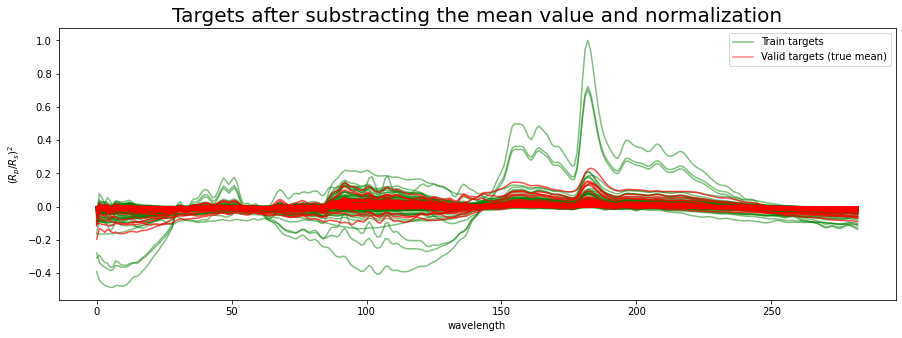

In [84]:
plt.figure(figsize=(15,5))

for i in range (240) :
    plt.plot(wls, train_targets_norm[i], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (60) :
    plt.plot(wls, valid_targets_norm[i], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets (true mean)')

plt.legend()
plt.xlabel('wavelength')
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('Targets after substracting the mean value and normalization', fontsize=20)
plt.show()



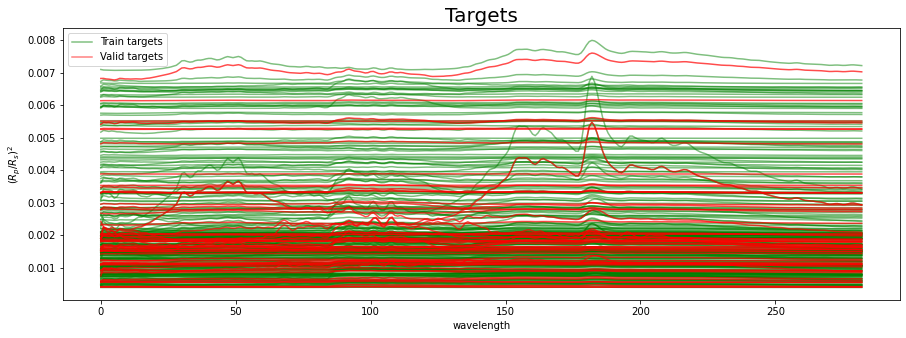

In [22]:
plt.figure(figsize=(15,5))

for i in range (240) :
    plt.plot(wls, train_targets[i], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train targets')
for i in range (60) :
    plt.plot(wls, valid_targets[i], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid targets')

plt.legend()
plt.xlabel('wavelength')
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('Targets', fontsize=20)
plt.show()





observations:

In [85]:
print(train_obs.shape, valid_obs.shape)



(538, 283, 187) (135, 283, 187)


In [86]:
###### Transpose #####
train_obs = train_obs.transpose(0, 2, 1)
valid_obs = valid_obs.transpose(0, 2, 1)
print(train_obs.shape, valid_obs.shape)



(538, 187, 283) (135, 187, 283)


We cut the transit to keep the in-transit. We assume an arbitrary transit duration of 40 instants with a transit occuring between 75 and 115.

In [87]:
##### Substracting the out transit signal #####
def suppress_out_transit(data, ingress, egress):
    data_in = data[:, ingress:egress,:]
    return data_in

ingress, egress = 75,115
train_obs_in = suppress_out_transit(train_obs, ingress, egress)
valid_obs_in = suppress_out_transit(valid_obs, ingress, egress)
print(train_obs_in.shape, valid_obs_in.shape)



(538, 40, 283) (135, 40, 283)


We remove the mean value of the in-transit to get relative data like the targets.

In [88]:
###### Substract the mean #####
def substract_data_mean(data):
    data_mean = np.zeros(data.shape)
    for i in range(data.shape[0]):
        data_mean[i] = data[i] - data[i].mean()
    return data_mean

train_obs_2d_mean = substract_data_mean(train_obs_in)
valid_obs_2d_mean = substract_data_mean(valid_obs_in)

print(train_obs_2d_mean.shape, valid_obs_2d_mean.shape)



(538, 40, 283) (135, 40, 283)


We use the same normalization as for the targets, i.e. between -1 and 1 centered on zero


In [89]:
##### Normalization dataset #####
def data_norm(data1, data2):
    data_min = data1.min()
    data_max = data1.max()
    data_abs_max = np.max([data_min, data_max])
    data1 = data1/data_abs_max
    data2 = data2/data_abs_max
    return data1, data2, data_abs_max


def data_normback(data, data_abs_max) :
    return data * data_abs_max

train_obs_norm, valid_obs_norm, data_abs_max = data_norm(train_obs_2d_mean, valid_obs_2d_mean)
print(train_obs_norm.shape, valid_obs_norm.shape, data_abs_max)



(538, 40, 283) (135, 40, 283) 0.017044884305467023


In [90]:
wls.shape


(283,)

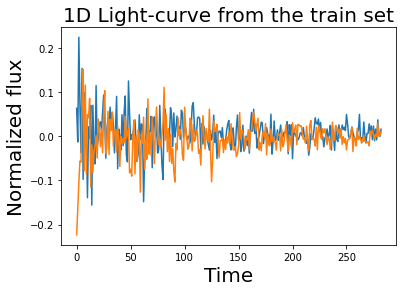

In [91]:
plt.plot(train_obs_norm[0][0])
plt.plot(train_obs_norm[1][0])
plt.title('1D Light-curve from the train set', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Normalized flux', fontsize=20)
plt.show()





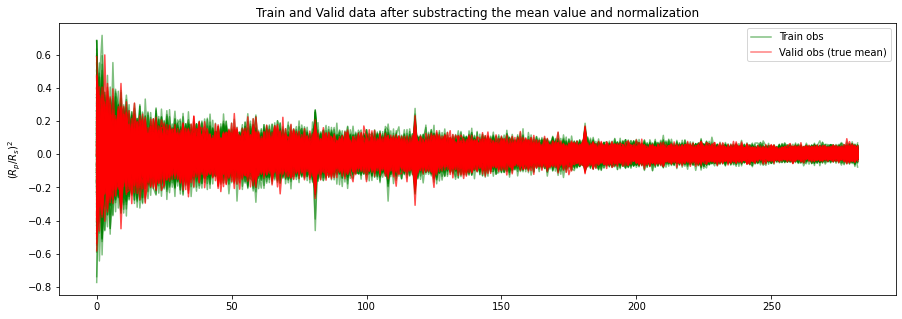

In [29]:
plt.figure(figsize=(15,5))
for i in range (train_obs.shape[0]) :
    plt.plot(wls, train_obs_norm[i,10], 'g-', alpha = 0.5)
plt.plot([], [], 'g-', alpha=0.5, label='Train obs')
for i in range (valid_obs.shape[0]) :
    plt.plot(wls, valid_obs_norm[i,10], 'r-', alpha = 0.7)
plt.plot([], [], 'r-', alpha=0.5, label='Valid obs (true mean)')

plt.legend()
plt.ylabel(f'$(R_p/R_s)^2$')
plt.title('Train and Valid data after substracting the mean value and normalization')
plt.show()



## Train 2D CNN

Data and directories


In [93]:
output_dir= '/home/ulaval.ca/maelr5/scratch/2Dunet_output'

ckpt_dir= '/home/ulaval.ca/maelr5/scratch/2Dunet_output/checkpoints'


In [94]:
output_dir, ckpt_dir


('/home/ulaval.ca/maelr5/scratch/2Dunet_output',
 '/home/ulaval.ca/maelr5/scratch/2Dunet_output/checkpoints')

## trainer callbacks

In [95]:
subtask = '2DCNN'

# Trainer callbacks
callbacks = []
callbacks.append(
    ModelCheckpoint(
        monitor='val_loss',
        save_top_k=1,
        save_last=True,
        dirpath=ckpt_dir+f'/{subtask}/',
        filename=f'{subtask}_{task}'+'-{epoch}-{val_loss:.2f}',
        verbose=False,
        mode='min',
        # dirpath=str(ckpt_dir),
    )
)

# callbacks.append(
#     EarlyStopping(
#         monitor='val_loss',
#         patience=20,
#         mode='min',
#     )
# )
    
callbacks.append(LearningRateMonitor(logging_interval="epoch"))

    

## create 2D UNet model and pl module

In [96]:
import torchvision.transforms.functional as TF
# optimizer
lr = 0.001

# dataloader
batch_size = 32

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    )
    return conv


class UNet2D(nn.Module):
    def __init__(
        self, input_channels=1, output_channels=1, features=[64, 128, 256, 512]
    ):
        super(UNet2D, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.input_channels = input_channels
        # self.output_channels = output_channels

        # down part of UNet
        for feature in features:
            self.downs.append(double_conv(input_channels, feature))
            input_channels = feature

        # up part of UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2,
                    feature,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.ups.append(double_conv(feature * 2, feature))

        self.bottleneck = double_conv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], output_channels, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1,features[0]))
        self.linear = nn.Linear(features[0],283)

    def forward(self, x):
        x = x.unsqueeze(1).float()
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        x = self.final_conv(x)
        x = self.avgpool(x)
        x = Flatten()(x)
        return self.linear(x)


class Base2DModule(pl.LightningModule):
    def __init__(self, train_data, train_labels, valid_data, valid_labels):
        super().__init__()

        self.model = UNet2D()
        self.save_hyperparameters()
        self.loss = nn.MSELoss()
        # print(train_data.dtype, valid_data.dtype)
        self.tr = MyDataset(train_data, train_labels)
        # print(self.train)
        self.v = MyDataset(valid_data, valid_labels)
        # self.test = 
        self.validation_step_outputs = []

    def train_dataloader(self):
        train_loader = DataLoader(self.tr, batch_size=batch_size, shuffle=True, num_workers=4)
        # print(train_loader)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(self.v, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader

    # def test_dataloader(self):
    #     test_dataloader = DataLoader(self.test, batch_size=batch_size)
    #     return test_dataloader
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200 , gamma=0.2)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        x, y = batch

        batch_size = x.size(0)
        y = y.float()
        # x = x.view(batch_size, -1).float()
        # print(x.shape, y.shape)

        logits = self(x)
        loss = self.loss(logits, y).float()
        self.log('train_loss', loss, on_step=True, on_epoch=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()

        batch_size = x.size(0)
        # x = x.view(batch_size, -1)

        logits = self(x)
        loss = self.loss(logits, y)
        self.validation_step_outputs.append(loss)
        self.log('val_loss', loss)

        return loss
    
    def on_validation_epoch_end(self):
        avg_val_loss = torch.tensor([x for x in self.validation_step_outputs]).mean()

        self.log('avg_val_loss', avg_val_loss, prog_bar=True)
        self.validation_step_outputs.clear()  # Free memory
    
    

## fit the data

In [97]:
train_obs_norm.shape

(538, 40, 283)

In [ ]:

csv_logger = CSVLogger(output_dir + "/csv_logs/", name=subtask)
max_epochs = 200

# make Pytorch Lightning trainer
trainer = pl.Trainer(
    logger=csv_logger,
    max_epochs=max_epochs,
    callbacks=callbacks,
    accelerator = 'gpu',
    devices = 1,
    log_every_n_steps=10,
)

ckpt_resume_path = '/home/ulaval.ca/maelr5/scratch/2Dunet_output/checkpoints/2DCNN/last.ckpt'
module2 = Base2DModule(train_obs_norm, train_targets_norm, valid_obs_norm, valid_targets_norm)

print('Running ...')
# fitting procedure
trainer.fit(
    model=module2,
    ckpt_path=ckpt_resume_path,
)
print('Done.')


/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cvmfs/soft.computecanada.ca/easybuild/software/2020 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /scratch/maelr5@ulaval.ca/2Dunet_output/checkpoints/2DCNN exists and is not empty.
Restoring states from the checkpoint path at /home/ulaval.ca/maelr5/scratch/2Dunet_output/checkpoints/2DCNN/last.ckpt


Running ...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | UNet2D  | 31.1 M | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31.1 M    Total params
124.220   Total estimated model params size (MB)
Restored all states from the checkpoint at /home/ulaval.ca/maelr5/scratch/2Dunet_output/checkpoints/2DCNN/last.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## visualize train val loss

   avg_val_loss  epoch  lr-Adam  step  train_loss_epoch  train_loss_step  \
0           NaN    NaN    0.001     0               NaN              NaN   
1           NaN    0.0      NaN     9               NaN            0.006   
2      0.010728    0.0      NaN    16               NaN              NaN   
3           NaN    0.0      NaN    16          0.024979              NaN   
4           NaN    NaN    0.001    17               NaN              NaN   

   val_loss  
0       NaN  
1       NaN  
2  0.010718  
3       NaN  
4       NaN  


/tmp/ipykernel_1379816/2184719983.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename({'train_loss_epoch':'loss'}, axis=1, inplace=True)
/tmp/ipykernel_1379816/2184719983.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['mode'] = 'train_loss_epoch'
/tmp/ipykernel_1379816/2184719983.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.rename({'avg_val_loss'

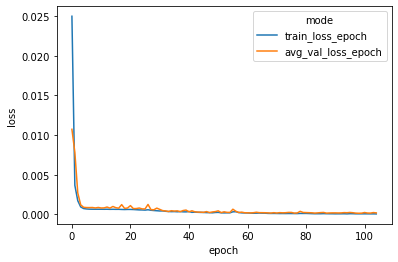

In [45]:
df_metrics1 = pd.read_csv("/home/ulaval.ca/maelr5/scratch/2Dunet_output/csv_logs/2DCNN/version_0/metrics.csv")
df_metrics2 = pd.read_csv("/home/ulaval.ca/maelr5/scratch/2Dunet_output/csv_logs/2DCNN/version_1/metrics.csv")

cnn1d_csv = pd.concat([df_metrics1, df_metrics2], axis=0, )
# print(len(cnn1d_csv))
print(cnn1d_csv.head())


# max_epochs=5
df1 = cnn1d_csv[['epoch','train_loss_epoch']]
df1.rename({'train_loss_epoch':'loss'}, axis=1, inplace=True)
df1['mode'] = 'train_loss_epoch'

df2 = cnn1d_csv[['epoch','avg_val_loss']]
df2.rename({'avg_val_loss':'loss'}, axis=1, inplace=True)
df2['mode'] = 'avg_val_loss_epoch'

results = pd.concat([df1, df2], ignore_index=True, sort=False)

# results

ax1 = sns.lineplot(data=results, x ='epoch' , y='loss', hue='mode')

# plt.xticks(np.arange(max_epochs))

plt.show()



## 2D UNet inference

In [98]:

# https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html#lightningmodule-from-checkpoint
model = Base2DModule.load_from_checkpoint("/home/ulaval.ca/maelr5/scratch/2Dunet_output/checkpoints/2DCNN/2DCNN_2Dunet-epoch=98-val_loss=0.00.ckpt").cpu()
# disable randomness, dropout, etc...
model.eval()
# predict with the model
y_hat = model(torch.tensor(valid_obs_norm))
print(y_hat.shape)



/home/ulaval.ca/maelr5/astronomy/MLSP-Project/myvenv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([135, 283])


## Postprocessing and visualisation

We obtain uncertainties on the predictions by computing a MCDropout.


In [ ]:
nb_dropout = 5

def NN_uncertainity(model, x_test, targets_abs_max, T=5):
    predictions = []
    for _ in range(T):
        pred_norm = model(torch.tensor(x_test)).detach().numpy()
        pred = targets_norm_back(pred_norm, targets_abs_max)
        predictions += [pred]
    mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
    return mean, std


if do_the_mcdropout :
    spectre_valid_shift, spectre_valid_shift_std = NN_uncertainity(model, valid_obs_norm, targets_abs_max, T = nb_dropout)

else :

    pred_valid_norm = model.predict([valid_obs_norm])
    pred_valid = targets_norm_back(pred_valid_norm, targets_abs_max)
    spectre_valid_shift = pred_valid
    spectre_valid_shift_std = spectre_valid_shift*0.1

    

In [ ]:
residuals = valid_targets_shift - spectre_valid_shift
print('MSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')



In [ ]:
# np.save(f'{output_dir}/pred_valid_shift.npy', spectre_valid_shift)
# np.save(f'{output_dir}/targ_valid_shift.npy', valid_targets_shift)
# np.save(f'{output_dir}/std_valid_shift.npy', spectre_valid_shift_std)



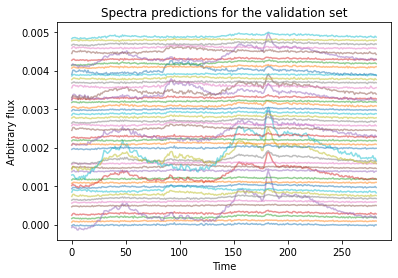

In [35]:
plt.figure()
for i in range (50) :
    plt.plot(spectre_valid_shift[-i]+0.0001*i, '-', alpha = 0.5)
plt.title('Spectra predictions for the validation set')
plt.xlabel('Time')
plt.ylabel('Arbitrary flux')
plt.show()



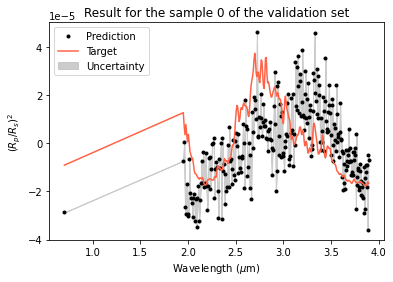

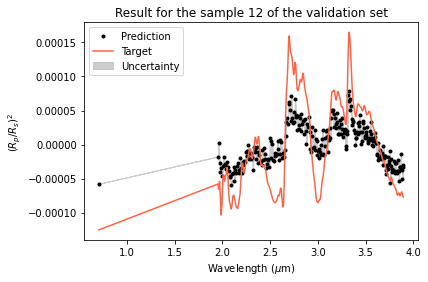

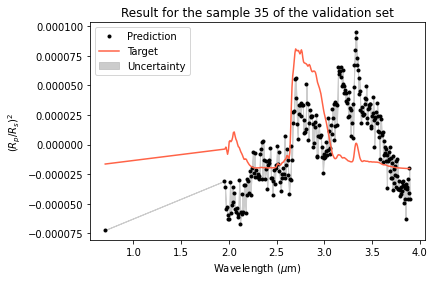

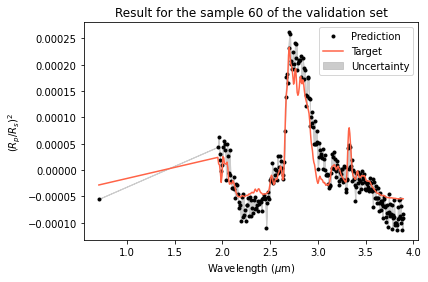

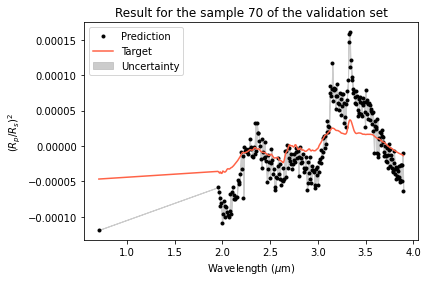

In [36]:
list_valid_planets = [0, 12, 35, 60, 70]
wavelength = np.loadtxt('/home/ulaval.ca/maelr5/scratch/ariel-data-challenge/wavelengths.csv', skiprows=1, delimiter = ',')
uncertainty = spectre_valid_shift_std
for i in (list_valid_planets):
    plt.figure()
    plt.title('Result for the sample {} of the validation set'.format(i))
    plt.plot(wavelength, spectre_valid_shift[i], '.k', label = 'Prediction')
    plt.plot(wavelength, valid_targets_shift[i], color = 'tomato', label = 'Target')
    plt.fill_between(wavelength, spectre_valid_shift[i] - spectre_valid_shift_std[i], spectre_valid_shift[i] + spectre_valid_shift_std[i], color='silver', alpha = 0.8, label = 'Uncertainty')
    plt.legend()
    plt.ylabel(f'$(R_p/R_s)^2$')
    plt.xlabel(f'Wavelength ($\mu$m)')
    plt.show()


